# "Proof" of noise ceiling by simulation

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_predict, GroupKFold
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from tqdm import tqdm_notebook

Define functions.

In [148]:
class Dataset:
    
    def __init__(self, P, N_per_class, K, R, verbose=False):
        self.P = P
        self.N_per_class = N_per_class
        self.N = N_per_class * K
        self.K = K
        self.R = R
        self.verbose = verbose
        self.rep_idx = np.repeat(np.arange(self.N), R)
        self.y = None
        self.X = None
        self.ohe = None  # added later
    
    def generate(self, signal=0.1, inconsistency=5):
        """ Generates pseudo-random data (X, y). 
        
        Parameters
        ----------
        signal : float
            "Amount" of signal added to X to induce corr(X, y)
        """

        X_unrep = np.random.normal(0, 1, (self.N, self.P))
        self.X = np.concatenate([X_unrep for _ in range(self.R)])  # repeat R times!
        
        # Generate "unrepeated" labels
        y_unrep = np.repeat(np.arange(self.K), self.N_per_class)
        
        # Generate random labels, repeated R times, simulating
        # inconsistency in subject ratings (sometimes anger, sometimes happiness, etc.)
        shifts = np.random.normal(0, inconsistency, R).astype(int)
        self.y = np.concatenate([np.roll(y_unrep, shifts[ii]) for ii in range(R)])

        # Add signal
        for k in range(self.K):
            self.X[self.y == k, k] += signal
            
        self.ohe = OneHotEncoder(sparse=False, categories='auto')
        self.ohe.fit(y_unrep[:, np.newaxis])
        
    def compute_noise_ceiling(self, use_prob=True):
        """ Estimates the best prediction and score (noise ceiling) given the 
        inconsistency in the labels.

        Parameters
        ----------
        use_prob : bool
            Whether to evaluate probabilistic performance or binarized
        """

        # Get 2d version of y, shape (N / reps, reps)
        y2d = np.c_[[self.y[self.N*i:self.N*(i+1)] for i in range(self.R)]].T

        # Magic below! Count the number of classes across repetitions of the same sample ...
        counts = np.apply_along_axis(np.bincount, 1, y2d, minlength=self.K)

        # Pre-allocate best prediction array
        best_pred = np.zeros_like(counts, dtype=float)    

        for ii in range(counts.shape[0]):
            # Determine most frequent label across reps
            opt_class = np.where(counts[ii, :] == counts[ii, :].max())[0]

            if use_prob:
                # Set prediction of the "optimal class" to 1 / num_opt_classes (ties)
                best_pred[ii, opt_class] = 1 / len(opt_class)
            else:
                rnd_class = np.random.choice(opt_class, size=1)  
                best_pred[ii, rnd_class] = 1

        # Repeat best possible prediction R times
        best_pred = np.tile(best_pred.T, R).T

        # Convert y to one-hot-encoded array
        y_ohe = self.ohe.transform(self.y[:, np.newaxis])

        # Compute best possible score ("ceiling")
        self.ceiling = roc_auc_score(
            y_ohe,
            best_pred,
            average=None if use_prob else 'micro'
        )
        
        if self.verbose:
            print(f"Ceiling: {np.round(self.ceiling, 2)}")

    def compute_model_performance(self, estimator, use_prob=True, cv=None, stratify_reps=False):
        
        # Fit actual model
        if cv is None:
            estimator.fit(self.X, self.y)
            preds = estimator.predict(self.X)
        else:
            preds = cross_val_predict(
                estimator, self.X, self.y, cv=cv,
                groups=self.rep_idx if stratify_reps else None
            )
        
        # Compute actual score (should be > ceiling)
        y_ohe = self.ohe.transform(self.y[:, np.newaxis])
        self.score = roc_auc_score(
            self.ohe.transform(self.y[:, np.newaxis]),
            self.ohe.transform(preds[:, np.newaxis]),
            average=None if use_prob else 'micro'
        )
        
        if self.verbose:
            print(f"Score: {np.round(self.score, 2)}")
        
        self.diff = self.ceiling - self.score

## 1. Within-subject, no CV
First, let's check it out for within-subject ratings. We'll define some simulation parameters.

In [153]:
P = 1000  # number of features
N_per_class = 10  # number of samples per class
K = 3  # number of classes [0 - K]
R = 4  # how many repetitions of each sample
estimator = make_pipeline(StandardScaler(), SVC(kernel='linear'))
iters = 100

ds = Dataset(P=P, N_per_class=N_per_class, K=K, R=R, verbose=False)

scores = np.zeros((iters, K))
ceilings = np.zeros((iters, K))
diffs = np.zeros((iters, K))

for i in tqdm_notebook(range(iters)):
    ds.generate(signal=0, inconsistency=5)
    ds.compute_noise_ceiling()
    ds.compute_model_performance(estimator)
    scores[i, :] = ds.score
    ceilings[i, :] = ds.ceiling
    diffs[i, :] = ds.diff

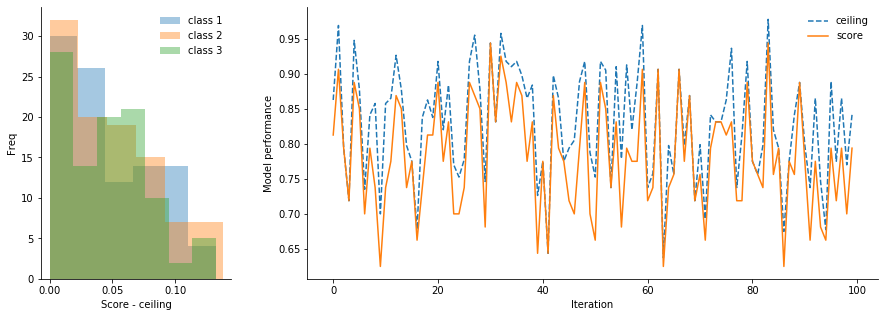

In [154]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 3]})
for i in range(K):
    sns.distplot(diffs[:, i], kde=False, ax=axes[0])

axes[0].set_xlabel('Score - ceiling')
axes[0].set_ylabel('Freq')
axes[0].legend([f'class {i+1}' for i in range(ds.K)], frameon=False)

axes[1].plot(ceilings.mean(axis=1), ls='--')
axes[1].plot(scores.mean(axis=1))
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Model performance')
axes[1].legend(['ceiling', 'score'], frameon=False)
sns.despine()

## 2. With CV

In [140]:
ds = Dataset(P=P, N_per_class=N_per_class, K=K, R=R, verbose=False)

scores = np.zeros((iters, K))
ceilings = np.zeros((iters, K))
diffs = np.zeros((iters, K))

for i in tqdm_notebook(range(iters)):
    ds.generate(signal=0, inconsistency=5)
    ds.compute_noise_ceiling()
    ds.compute_model_performance(estimator, cv=GroupKFold(n_splits=10), stratify_reps=True)
    scores[i, :] = ds.score
    ceilings[i, :] = ds.ceiling
    diffs[i, :] = ds.diff

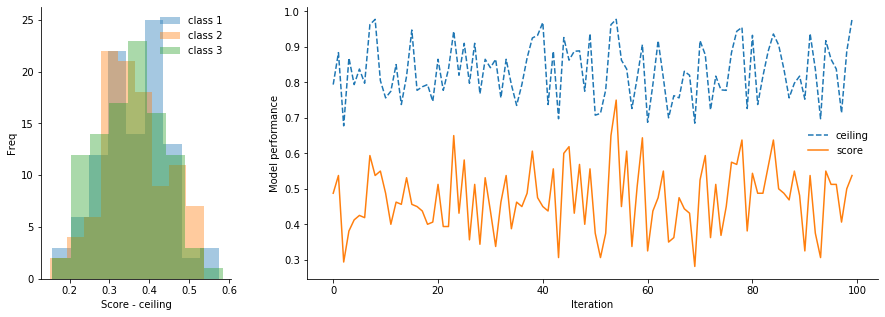

In [141]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 3]})
for i in range(K):
    sns.distplot(diffs[:, i], kde=False, ax=axes[0])

axes[0].set_xlabel('Score - ceiling')
axes[0].set_ylabel('Freq')
axes[0].legend([f'class {i+1}' for i in range(ds.K)], frameon=False)

axes[1].plot(ceilings.mean(axis=1), ls='--')
axes[1].plot(scores.mean(axis=1))
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Model performance')
axes[1].legend(['ceiling', 'score'], frameon=False)
sns.despine()